# LLAMA2 Tuning

This notebook contains example of fine-tuning LLAMA-2 7B (smallest possible) for sequence classification using exemple dataset of 20 news groups from scikit-learn. 20NG dataset is relatively simple and has pletny of examples, so it can be used as learning example (learning for the user, not for the model).

### Resources

* https://huggingface.co/blog/ram-efficient-pytorch-fsdp
* https://huggingface.co/blog/dpo-trl
* https://medium.com/@ogbanugot/notes-on-fine-tuning-llama-2-using-qlora-a-detailed-breakdown-370be42ccca1
* https://www.reddit.com/r/LocalLLaMA/comments/16lka4y/any_help_with_setting_up_training_for_llama2_7b/?rdt=55916
* https://huggingface.co/docs/accelerate/main/en/usage_guides/model_size_estimator
* https://huggingface.co/blog/4bit-transformers-bitsandbytes

### Setup

In [22]:
from functools import partial

import evaluate
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from peft import LoraConfig, PeftModel
from sklearn.datasets import fetch_20newsgroups
from sklearn import metrics
from transformers import AutoTokenizer, LlamaForSequenceClassification, BitsAndBytesConfig, TrainingArguments, DataCollatorWithPadding, Trainer
from trl import SFTTrainer

In [23]:
round2 = partial(round, ndigits=2)  # util for later

def tensor_size_in_gb(t):
    """Returns tensor size in gigabytes"""
    return t.nelement() * t.element_size() / 1024 ** 3

### Dataset

Fetch dataset using sklearn utils and convert them to pandas DataFrames.

In [24]:
newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

In [25]:
train_data = pd.DataFrame(
    data=np.column_stack([newsgroups_train["data"], newsgroups_train["target"]]),
    columns=["data", "targets"]
)

test_data = pd.DataFrame(
    data=np.column_stack([newsgroups_test["data"], newsgroups_test["target"]]),
    columns=["data", "targets"]
)

train_data["targets"] = train_data["targets"].astype(int)
test_data["targets"] = test_data["targets"].astype(int)

In [26]:
id2label = {index: label for index, label in enumerate(newsgroups_train["target_names"])}
label2id = {label: index for index, label in enumerate(newsgroups_train["target_names"])}

### Tokenization

LLAMA-2 is gated, for the first download token needs to be passed (token="SECRET_TOKEN") later model is downloaded and only loaded from local storage. For now, just `tokenizer` is needed.

In [27]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

In [28]:
tokens = tokenizer(train_data["data"].tolist())
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

See the length distribution, to decide, if truncation will not result in large loss of data.

In [29]:
pd.Series(tokens["input_ids"], name="length").apply(len).describe().apply(round2).to_frame()

,length
count,11314.00
mean,670.76
std,2117.95
min,47.00
25%,260.00
50%,393.00
75%,607.00
max,54271.00


Amount of examples longer than context is small (~1%), so simple truncation can be used, instead of chunking the inputs.  

In [30]:
(pd.Series(tokens["input_ids"]).apply(len) > 4096).value_counts()

False    11184
True       130
Name: count, dtype: int64

Add padding token, which is not present by default in LLAMA-2 tokenizer (see resoruces for more info)

In [31]:
tokenizer.add_special_tokens({"pad_token": "[PAD]"})
tokenizer.pad_token = tokenizer.eos_token
tokenizer.model_max_length = 4096
tokenizer.padding_side = "right"

Convert test data to HuggingFace dataset, to run the model on some example and see how it behaves. Usually training is described first, but in this case, first example with randomly initialized task head will be run, to make sure model return expected shapes etc.

In [32]:
dataset = Dataset.from_pandas(test_data[["data", "targets"]])
dataset = dataset.map(lambda row: tokenizer(row["data"], truncation=True, padding=True), batched=True)
dataset.set_format(type="torch", device="cuda", columns=["input_ids", "attention_mask", "targets"])

Map:   0%|                                                                                                                                                                  | 0/7532 [00:00<?, ? examples/s]

Map: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7532/7532 [00:11<00:00, 675.19 examples/s]


In [33]:
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=False)

### Task Model

Load LLAMA-2 7B model and convert it to sequence classification model with random task head.

In [34]:
# hardware configuration
nf4_config = BitsAndBytesConfig(
   load_in_8bit=True,
   llm_int8_enable_fp32_cpu_offload=True,
)

In [35]:
# LLAMA-2 is gated, for the first download token needs to be passed (token="SECRET_TOKEN")
# later model is downloaded and only loaded from local storage
# the warning should indicate that downstream model was not trained, which is expected in this case
model = LlamaForSequenceClassification.from_pretrained(
    "meta-llama/Llama-2-7b-hf",
    quantization_config=nf4_config,
    load_in_8bit=True,
    use_cache=False,
    pad_token_id=tokenizer.pad_token_id,
    id2label=id2label,
    label2id=label2id,
)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.52s/it]
Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
sum(param.numel() for param in model.parameters())

6607425536

Checkout the model structure.

In [37]:
task_head = torch.nn.Sequential(
    torch.nn.Linear(in_features=4096, out_features=20, bias=False),
    torch.nn.Softmax(dim=1),
)

task_head = task_head.to(model.device)  # cast to CUDA device
task_head = task_head.to(model.dtype)  # cast to mixed precision
model.score = task_head

In [38]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 3                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   8805 MiB |  36343 MiB |    774 GiB | 784098 MiB |
|       from large pool |   8699 MiB |  36309 MiB |    773 GiB | 783874 MiB |
|       from small pool |    106 MiB |    106 MiB |      0 GiB |    224 MiB |
|---------------------------------------------------------------------------|
| Active memory         |   8805 MiB |  36343 MiB |    774 GiB | 784098 MiB |
|       from large pool |   8699 MiB |  36309 MiB |    773 GiB |

In [39]:
parameters_size = sum(tensor_size_in_gb(param) for param in model.parameters()) 
buffer_size = sum(tensor_size_in_gb(buffer) for buffer in model.buffers())

print(f"Model size: {(parameters_size + buffer_size):.3f} GB")

Model size: 6.339 GB


In [40]:
dataset_size = sum(tensor_size_in_gb(batch["input_ids"]) + tensor_size_in_gb(batch["attention_mask"]) for batch in test_dataloader)
print(f"Dataset size: {dataset_size:.3f} GB")

Dataset size: 0.460 GB


In [41]:
def predict(model, dataloader, limit_batches=None):
    outputs = []
    targets = []
    
    for batch_idx, batch in enumerate(dataloader):
        if limit_batches and batch_idx >= limit_batches:
            break  # stop when limit reached
        # without this step torch will try to allocate crazy amount of memory for gradients
        with torch.no_grad():
            target = batch.pop("targets")
            pred = model(**batch)
            # store both prediction and target for given batch
            outputs.append(pred["logits"])
            targets.append(target)

    return torch.cat(outputs), torch.cat(targets)

In [42]:
%%time

predictions, targets = predict(model, test_dataloader, limit_batches=10)
predictions.shape

CPU times: user 1min 3s, sys: 133 ms, total: 1min 3s
Wall time: 1min 3s


torch.Size([80, 20])

In [43]:
predictions = torch.argmax(predictions, dim=1)

predictions = predictions.detach().cpu().numpy()
targets = targets.detach().cpu().numpy()

In [44]:
print(metrics.classification_report(y_pred=predictions.flatten(), y_true=targets.flatten(), zero_division=0.0))

              precision    recall  f1-score   support

           0       0.02      0.25      0.04         4
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         5
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         4
          10       0.00      0.00      0.00         3
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         4
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         2
          17       0.00    

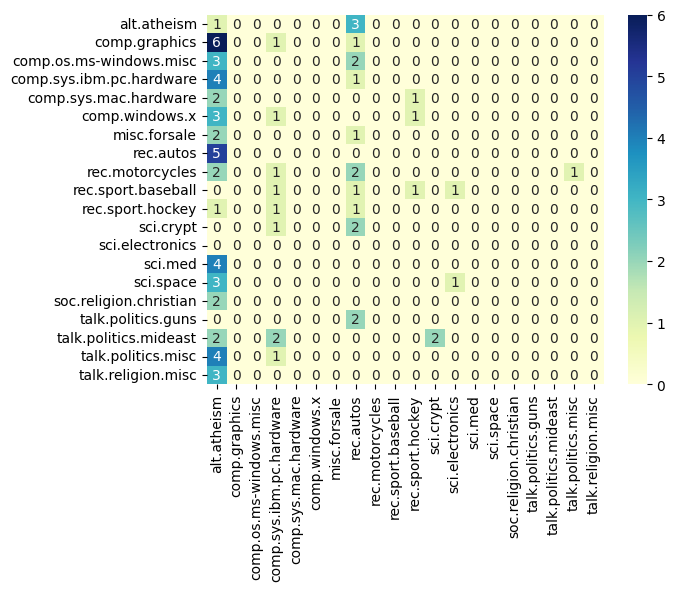

In [45]:
matrix = metrics.confusion_matrix(y_pred=predictions.flatten(), y_true=targets.flatten())
labels = list(model.config.id2label.values())

_ = sns.heatmap(matrix, annot=True, fmt="d", cmap="YlGnBu", xticklabels=labels, yticklabels=labels)